In [1]:
#!python3 -m pip install tables

In [2]:
## Importing dependencies-------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tables as tb
import random
import math
import warnings
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime as dt
import seaborn as sns
os.chdir('/Users/dhamada/Downloads/honey-bee-behavior/') ##New user? Change me!/Users/dhamada/Documents - MacBook Air/honey-bee-behavior
PATH = '/Users/dhamada/Downloads/honey-bee-behavior/' ##Me too!

#DELETED FREQ PARAMETER FROM DEFINITIONS_2018
from bees_lifetimetracking_2018data import datafunctions
from bees_lifetimetracking_2018data import definitions_2018 as bd
from bees_lifetimetracking_2018data import displayfunctions as bp
from bees_lifetimetracking_2018data import definitions2024 as bn

datafunctions.init(bd) 
bp.init(bd)
warnings.filterwarnings("ignore")


# Establishing date range and basic dataset information----------------------------------------------------
year = 2018
startday = pd.Timestamp(year,7,16)  # actual, for 2018:   16 July  (cameras turned on)
endday = pd.Timestamp(year,10,9)    # actual, for 2018:   was 10 September, but is now 09 Oct
alldaytimestamps = pd.date_range(start=startday,end=endday,freq='D')
numdays = len(alldaytimestamps)
numbees = 4096  # This is the total number of barcodes, NOT the total number of bees actually tracked
numsubstrates = 10 # 10 actual substrates, and then 0 for undefined
comb_daynums = np.array([ 0,  5, 10, 15, 20, 26, 30, 35, 40, 44, 65, 75, 85]) + 16 - startday.day  # days from start day, assuming start day is in July

# get bee cohort data, and just process these for a single one
cohort_data = pd.read_csv(PATH + 'bees_lifetimetracking_2018data/all_cohorts.csv')

cohort_colornames = np.unique(cohort_data['cohort'])
cohort_tagids = [np.array(cohort_data[cohort_data['cohort']==name]['beeID']) for name in cohort_colornames]
cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0]) for c in cohort_colornames])
pix = bd.xpixels #for methods in definitions2024

def rawLeaveEvents(daynum, beeTraj, hiveEvents):
    dfIntersect = hiveEvents.merge(beeTraj, how='right', on = ['uid','framenum'])
    #exit_dist------------------------------------------------------------------------------------
    dfIntersect = getExitDist(dfIntersect)
    
    result = dfIntersect[((dfIntersect['status']=='leave') | (dfIntersect['status']=='return'))]
    #result = dfIntersect[((dfIntersect['status']=='return'))]
    
    result = result.sort_values(by=['daynum', 'uid', 'framenum'])
    
    result['next status'] = result['status'].shift(-1)
    result['next uid'] = result['uid'].shift(-1)
    result['next framenum'] = result['framenum'].shift(-1)
    
    conditions = [
        ((result['status'] == 'leave') & (result['next status'] == 'return') & (result['next uid'] == result['uid']) & (result['next framenum']- result['framenum'] < 1000)),
        ((result['status'] == 'leave') & (result['next status'] == 'return') & (result['next uid'] == result['uid']) & (result['next framenum']- result['framenum'] >= 1000)),
        (result['status'] == 'return'),
        ((result['status'] == 'leave') & (result['next uid'] != result['uid']))
    ]
    choices = ['short with return', 'long with return', 'return event', 'disappeared']
    result['event type'] = np.select(conditions, choices, default='not sure')
    
    
    #result = dfIntersect[dfIntersect['exit_dist']<=1000] #threshold = 1000
    #result = dfIntersect[dfIntersect['status']=='leave']
    #result = dfIntersect[dfIntersect['event type']=='long with return']
    
    result = bn.numOfDanceFloorVisits(result, beeTraj, 1800)
    
    return result

def loadData(daynum):
    global dfday, day_uids, day_ages, boolInHiveByIDByTime, bee_obs, bee_exitdist, numtimedivs
    ### DID THE BEE LEAVE? ------------------------------------------------------------------
    dataDir = PATH + 'df_day1min_alldays/'
    dfday = pd.read_hdf('{}df_day1min_{:0>2}.hdf'.format(dataDir,daynum))
    numtimedivs = len(dfday['timedivision'].unique()) # minutes in a day
    day_uids, day_ages, boolInHiveByIDByTime, bee_obs, bee_exitdist = datafunctions.get_inout_estimates(dfday, exitdistthreshold=1000, numtimedivs=numtimedivs)

## Adds column of distances from the exit
def getExitDist(df):
    df['exit_dist'] = datafunctions.getexitdistance(df.x,df.y,df.camera)
    return df

## Creates dataframe based on given day and adds available information.
def getBeeTraj(daynum):
    if daynum >= 50:
        datadir = PATH + 'beetrajectories_days_050_to_085/'
    else:
        datadir = PATH + 'beetrajectories_days_000_to_049/'
    
    beeTrajectoriesByFrame = pd.read_hdf('{}beetrajectories_{:0>3}.hdf'.format(datadir,daynum)) #data per frame in which each bee was seen
    beeTrajectoriesByFrame = getExitDist(beeTrajectoriesByFrame)
    beeTrajectoriesByFrame= bn.crossedDanceFloor(beeTrajectoriesByFrame, pix)
    beeTrajectoriesByFrame = bn.numOfDanceFloorVisitsRUNNINGTOTAL(beeTrajectoriesByFrame)
    return beeTrajectoriesByFrame

def getHiveEvents(daynum):
    # boolInHiveByIDByTime into dataframe ----------------------------------------------------
    inHive = pd.DataFrame(boolInHiveByIDByTime)
    inHive = inHive.T #transpose so rows = time and cols = uid
                                
    #get hive statuses by taking difference on axis 0 (rows, which represent time)
    hive_statuses_list = np.diff(inHive, axis = 0) # TODO document code
    #print(len(hive_statuses_list[1])) #PRINT CHECK (len 1439, len of each is 1435)
    
    # translate time to framenum (assuming 3 frames per second)-------------------------------
    frames_per_day = 24*60*60*3
    frames_per_timedivision = frames_per_day / numtimedivs
    
    """
    inHive['index'] = range(len(inHive))
    inHive['minsPastMidnight'] = inHive['index']*1 #bin size = 1min (see datafunctions.py), TODO un-hardcode
    
    
    inHive['framenum'] = inHive['index']*frames_per_timedivision
    """
    
    hive_statuses_by_uid = []
    
    #return [i for i in zip(day_uids,hive_statuses_list)]
    
    hive_statuses_list = np.transpose(hive_statuses_list) # First index is beeUID, second is minute
    for uid, hive_statuses in zip(day_uids,hive_statuses_list):
        for hive_status in hive_statuses:
            hive_statuses_by_uid.append([uid,hive_status])
    df_hive_events = pd.DataFrame(hive_statuses_by_uid,columns=['uid','diff'])
    df_hive_events['index'] = range(len(df_hive_events))
    
    #minutes and framenum columns---------------------------------------------------------------
    result = []
    numEntriesPerUid = len(df_hive_events[df_hive_events['uid'] == df_hive_events['uid'].iat[0]])
    for value in df_hive_events['index']:
        result.append(value % numEntriesPerUid)
    df_hive_events['min'] = result
    
    df_hive_events['framenum'] = df_hive_events['min']*frames_per_day/(24*60) #use time_functions_2019.py from git repo to fix!!
    
    df_hive_events = df_hive_events[['index', 'uid', 'diff', 'min', 'framenum']]
    
    #stauses--------------------------------------------------------------------------------------
    conditions = [
        (df_hive_events['diff'] == -1.0),
        (df_hive_events['diff'] == 1.0),
        (df_hive_events['diff'] == 0.0),
    ]
    choices = ['leave', 'return', 'no change']
    df_hive_events['status'] = np.select(conditions, choices, default='not sure')
    
    """
    for plotting purposes, single out rows in beetraj df and surrounding rows to track data.
    
    add function to do exit distance and num dance floor visits for selected rows (new df)
    """
    
    return df_hive_events

#defines frameNew, frameReturn, frameGone, and returns leaveEvents dataFrame
def getLeaveEvents(daynum, beeTraj, hiveEvents):
    rawEvents = pd.DataFrame()
    rawEvents = rawLeaveEvents(daynum, beeTraj, hiveEvents)
    
    filteredEvents = pd.DataFrame()
    filteredEvents, frameNew, frameReturn, frameGone = getPlottingEvent(daynum, df, frame, beeID, framesBefore, framesAfter)
    
    #filteredEvents = rawEvents.drop(columns=['index', 'diff', 'status'])
    return filteredEvents
# Modify to check location before leaving and time gone.

def plotEvent(daynum, frame, beeID, framesBefore, framesAfter):
    # getting desired rows
    plotPoint = pd.DataFrame()
    plotPoint, frameNew, frameReturn, frameGone = bn.getPlottingEvent(daynum, beeTraj, frame, beeID, framesBefore, framesAfter)
 
    # create figure x = framenum, y = y, color gradient = x
    plt.figure(figsize=(10, 6))
    
    #""" EXIT DISTANCE VS FRAMENUM
    plt.scatter(plotPoint['framenum'], plotPoint['exit_dist'], s=10, alpha=0.8, label='Data')

    #labels
    plt.xlabel('Frame Number')
    plt.ylabel('Exit Distance')
    plt.title('Plot of Exit Distance vs. Frame Number')
    #"""
    
    """ Y VS FRAMENUM, X VARIATION
    plt.scatter(plotPoint['framenum'], plotPoint['y'], c=plotPoint['x'], cmap='viridis', s=10, alpha=0.8, label='Data') 
    
    # if you'd like the graph to start at y = 0
    #plt.ylim([0, plotPoint['y'].max()+0.5])

    #gradient to represent x:
    cbar = plt.colorbar()
    cbar.set_label('X-Coordinate')

    #labels
    plt.xlabel('Frame Number')
    plt.ylabel('Y Coordinate')
    plt.title('Plot of Y-Coordinate vs. Frame Number with X-Coordinate Variation')
    """

    # red dashed line to indicate where the 'leave' event is
    plt.axvline(x=frameNew, color='lawngreen', linestyle='-', label='Leave')
    
    #new black line to indicate bee disappearance
    if(frameGone <= plotPoint['framenum'].max() + 20):
        plt.axvline(x=frameGone, color='black', linestyle='-', label='disappearance')
    if(frameReturn <= plotPoint['framenum'].max() + 20):
        if(frameReturn != -1):
            plt.axvline(x=frameReturn, color='red', linestyle='-', label='Return')
    """         
    print(frameNew)
    print(framesBefore)
    for frame in range(frameNew - framesBefore, frameNew+framesAfter): 
        if frame % 180 ==0: #180 frames = 1 minute
            plt.axvline(x=frame, color='grey', linestyle='-')
    """

    #Add grid and legend, then show plot
    plt.gca().yaxis.grid(True)
    plt.legend(loc = 'lower center')
    plt.show()

FRAMES_PER_SECOND = 3
def framenum_to_datetime(daynum,framenum,frames_per_second=FRAMES_PER_SECOND):
    return bd.alldaytimestamps[daynum] + dt.timedelta(seconds=int(framenum/frames_per_second))

#data should be beeTraj, duration in frames, visits threshold in frames
def NEWleavingEvents(data, exitThreshold, durationReq, dfVisitsThreshold): 
    '''
    data = data.sort_values(by=['daynum', 'uid', 'framenum'])
    data['framenum_diff'] = data.groupby(['daynum', 'uid'])['framenum'].shift(-1) - data['framenum']

    for i in range(1, len(data)):
        data.loc[i, 'status'] = 'no change'
        
        if ((data.loc[i, 'framenum_diff'] >= durationReq) & (data.loc[i, 'exit_dist'] <= exitThreshold)):
            data.loc[i, 'status'] = 'leave'
        if data.loc[i-1, 'status'] == 'leave':
            data.loc[i, 'status'] = 'return'
            
    data = data[data['status'] == 'leave']
    data = bn.numOfDanceFloorVisits(data, beeTraj, dfVisitsThreshold)
    data['datetime'] = data.apply(lambda row: framenum_to_datetime(row['daynum'], row['framenum']), axis=1)
    '''
    data = data.sort_values(by=['daynum', 'uid', 'framenum'])
    data['framenum_diff'] = data.groupby(['daynum', 'uid'])['framenum'].shift(-1) - data['framenum']
    data['status'] = 'no change'
    data.loc[(data['framenum_diff'] >= durationReq) & (data['exit_dist'] <= exitThreshold), 'status'] = 'leave'
    data['status'] = np.where(data['status'].shift(1) == 'leave', 'return', data['status'])
    
    data = data[data['status'] == 'leave']
    
    data = bn.numOfDanceFloorVisits(data, beeTraj, dfVisitsThreshold)
    #data['datetime'] = framenum_to_datetime(data['daynum'], data['framenum'])
    data['datetime'] = data.apply(lambda row: framenum_to_datetime(row['daynum'], row['framenum']), axis=1)
    return data

## 1. Data Generation

In [3]:
#STEP 1: Enter day number, minimum dist from exit in px, minimum time gone in frames, num of frames before to count dance floor visits
daynum = 20
exit_threshold = 1000 # in pixels
min_time_gone = 900 # 900 frames = 5 mins
time_threshold_historical_dfvists = 1800 # in frames

#loading...--------------------
loadData(daynum)
beeTraj = getBeeTraj(daynum)

leavingEvents = NEWleavingEvents(beeTraj, 1000, 900, 1800)
#------------------------------

In [4]:
#Prints your options of leaving events!
leavingEvents[['datetime', 'framenum', 'uid', 'recent_df_visits', 'framenum_diff', 'status']]

,datetime,framenum,uid,recent_df_visits,framenum_diff,status
13014,2018-08-05 13:17:24,143534,848,4.0,7620.0,leave
36541,2018-08-05 13:01:16,140629,1002,2.0,1494.0,leave
69799,2018-08-05 02:26:31,26375,1007,1.0,1914.0,leave
73625,2018-08-05 02:59:58,32396,1007,1.0,8917.0,leave
93250,2018-08-05 13:39:58,147596,1011,1.0,8175.0,leave
...,...,...,...,...,...,...
11061689,2018-08-05 21:29:44,232152,2951,2.0,19862.0,leave
11105035,2018-08-05 19:28:50,210391,2974,8.0,7130.0,leave
11253958,2018-08-05 22:34:16,243769,3054,3.0,1028.0,leave
11256550,2018-08-05 20:31:28,221664,3060,0.0,10790.0,leave


Leave:  243272
Return:  243670
Disappears:  256069


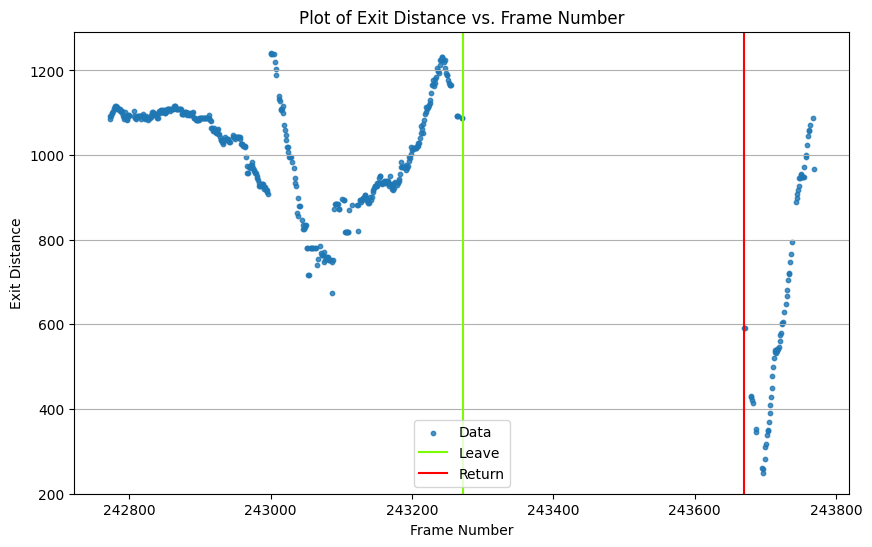

In [5]:
#STEP 2: Enter a framenumber, bee ID, number of frames before (to be plotted), and number of frames after!
frame = 243769
beeID = 3054

framesBefore = 500
framesAfter = 1000

#loading...----------------------
plotPoint = plotEvent(daynum, frame, beeID, framesBefore, framesAfter)
plotPoint
#--------------------------------

- num frames on df instead of num floor visits?

## 2. Final Cleaning + Exporting

In [6]:
allEvents = pd.merge(beeTraj, leavingEvents, how='left', indicator=True)
allEvents['status'] = allEvents['_merge'].map({'both': 'leave','left_only': 'no change'})

In [7]:
allEvents

,daynum,framenum,uid,x,y,camera,theta,exit_dist,cross_df,running_total_df_visits,framenum_diff,status,recent_df_visits,datetime,_merge
0,20,30343,846,767,2607,0,-2.84379,3958.265529,0,0,NaN,no change,NaN,NaT,left_only
1,20,30344,846,767,2599,0,-2.76173,3964.423035,0,0,NaN,no change,NaN,NaT,left_only
2,20,30345,846,790,2583,0,-2.17854,3962.170743,0,0,NaN,no change,NaN,NaT,left_only
3,20,30349,846,782,2583,0,-2.09134,3967.235435,0,0,NaN,no change,NaN,NaT,left_only
4,20,30350,846,790,2591,0,-2.18434,3955.977376,0,0,NaN,no change,NaN,NaT,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11294848,20,247363,3103,1841,5207,0,1.27930,1521.528836,0,10,NaN,no change,NaN,NaT,left_only
11294849,20,247364,3103,1841,5199,0,1.27623,1523.887791,1,11,NaN,no change,NaN,NaT,left_only
11294850,20,247365,3103,1841,5198,0,1.17175,1524.185356,1,11,NaN,no change,NaN,NaT,left_only
11294851,20,247366,3103,1846,5208,0,1.57168,1516.455077,0,11,NaN,no change,NaN,NaT,left_only


In [8]:
fewerFrames = allEvents.iloc[::3]
leaveOnly = allEvents[allEvents['status'] == 'leave']
allEventsFewer = pd.concat([fewerFrames, leaveOnly]).drop_duplicates()
allEventsFewer = allEventsFewer.reset_index(drop=True)


allEventsFewer = allEventsFewer.drop(columns=['_merge', 'cross_df', 'theta'])
allEventsFewer['datetime'] = allEventsFewer.apply(lambda row: framenum_to_datetime(row['daynum'], row['framenum']), axis=1)
allEventsFewer

,daynum,framenum,uid,x,y,camera,exit_dist,running_total_df_visits,framenum_diff,status,recent_df_visits,datetime
0,20,30343,846,767,2607,0,3958.265529,0,NaN,no change,NaN,2018-08-05 02:48:34
1,20,30349,846,782,2583,0,3967.235435,0,NaN,no change,NaN,2018-08-05 02:48:36
2,20,30352,846,751,2582,0,3987.721781,0,NaN,no change,NaN,2018-08-05 02:48:37
3,20,30369,846,703,2525,0,4062.238053,0,NaN,no change,NaN,2018-08-05 02:48:43
4,20,30372,846,720,2551,0,4031.374083,0,NaN,no change,NaN,2018-08-05 02:48:44
...,...,...,...,...,...,...,...,...,...,...,...,...
3765337,20,209021,2951,2679,4993,0,902.756889,2,23030.0,leave,1.0,2018-08-05 19:21:13
3765338,20,232152,2951,2839,5120,0,701.336581,4,19862.0,leave,2.0,2018-08-05 21:29:44
3765339,20,210391,2974,2806,4919,0,881.696660,8,7130.0,leave,8.0,2018-08-05 19:28:50
3765340,20,243769,3054,2960,4745,0,967.235752,5,1028.0,leave,3.0,2018-08-05 22:34:16


In [9]:
dfday

,Age,Num. observations,Honey,Brood care,Pollen,Dance floor,Other,Frame 0,Frame 1,Frame 2,...,Num. outside trips,Num. dance floor visits,Dispersion-minute avg.,Frame 0 - Num. crossings,Frame 1 - Num. crossings,Frame 2 - Num. crossings,Frame 3 - Num. crossings,Frame 4 - Num. crossings,Frame 5 - Num. crossings,timedivision
0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066395,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1439.0
2066396,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1439.0
2066397,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1439.0
2066398,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1439.0


In [10]:
print(dfday.columns)

Index(['Age', 'Num. observations', 'Honey', 'Brood care', 'Pollen',
       'Dance floor', 'Other', 'Frame 0', 'Frame 1', 'Frame 2', 'Frame 3',
       'Frame 4', 'Frame 5', 'Median speed', 'Speed IQR',
       'Speed 90th quantile', 'Dispersion (avg)', 'Exit distance (median)',
       'Fraction squares visited', 'Day number', 'Festoon', 'Empty comb',
       'blank1', 'blank2', 'Bee unique ID', 'Cohort ID', 'Num. outside trips',
       'Num. dance floor visits', 'Dispersion-minute avg.',
       'Frame 0 - Num. crossings', 'Frame 1 - Num. crossings',
       'Frame 2 - Num. crossings', 'Frame 3 - Num. crossings',
       'Frame 4 - Num. crossings', 'Frame 5 - Num. crossings', 'timedivision'],
      dtype='object')


In [11]:
ages = dfday[['Age', 'Bee unique ID']]

In [13]:
allEventsFewer.to_csv('allEventsFewer.csv')
ages.to_csv('ages.csv')

In [ ]:
allEventsFewer = allEventsFewer.merge(ages, left_on='uid', right_on='Bee unique ID', how='left')
allEventsFewer

In [ ]:
allEventsFewer = bn.numOfDanceFloorVisits(allEventsFewer, beeTraj, 1800) # by bee

In [1]:
allEventsFewer
allEventsFewer.to_csv('allEventsFewer.csv')

NameError: name 'allEventsFewer' is not defined